# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import re
import time
import seaborn as sns
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
RANDOM_STATE = 1234

## Подготовка данных

### Изучение данных из файла

In [3]:
df = pd.read_csv('/datasets/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Согласно документации к данным:

**Признаки**

- DateCrawled — дата скачивания анкеты из базы
- vehicle_type — тип автомобильного кузова
- registration_year — год регистрации автомобиля
- gearbox — тип коробки передач
- Power — мощность (л. с.)
- model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- fuel_type — тип топлива
- Brand — марка автомобиля
- not_repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак**
- Price — цена (евро)

**Вывод**
- Данных для анализа достаточно.
- Пропущенные данные в переменных: *vehicle_type, gearbox, model, fuel_type, not_repaired*. 

Переменные не влияющие на предсказане модели: *DateCrawled, RegistrationMonth, DateCreated, PostalCode, LastSeen*, параметр *NumberOfPictures* содержит токлько одно значение `0`.

### Обработка данных

Приведем названия столбцов датафрейма к нижнему регистру и змеиному стилю:

In [7]:
df.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', name).lower() for name in df.columns]

In [8]:
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


- **Дубликаты**

In [8]:
# Явные дубликаты
df.duplicated().sum()

4

In [9]:
df = df.drop_duplicates().reset_index(drop=True)

In [10]:
# Неявные дубликаты
display(df['vehicle_type'].unique())
display(df['gearbox'].unique())
display(df['fuel_type'].unique())
display(df['brand'].unique())

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

array(['manual', 'auto', nan], dtype=object)

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

- **Некорректные значения**

In [11]:
df['registration_year'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

Ограничим параметр `registration_year` значениями $\in [1910, 2019]$

In [12]:
print(len(df.query('registration_year < 1910')['registration_year']))
print(len(df.query('registration_year > 2019')['registration_year']))

66
105


Поскольку имеется небольшое количество объектов со значеними `registration_year`, выходящих за пределы выбранного диапазона, удалим иx из исходного датафрейма:

In [13]:
df = df.query("registration_year >= 1910 and registration_year <= 2019")

В параметре `power` значения заменим на медианное по группе `model`, так как много объектов с аномальными значениями. Но сначала устраним пропуски в параметре `model`. 

- **Пропуски**

In [14]:
df.isna().sum()

date_crawled              0
price                     0
vehicle_type          37319
registration_year         0
gearbox               19695
power                     0
model                 19630
kilometer                 0
registration_month        0
fuel_type             32767
brand                     0
not_repaired          71007
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

Пропущенные значения в параметре `model` заменим `unknown`:

In [15]:
df['model'] = df['model'].fillna('unknown')

Заменим значения в параметре `power`:

In [16]:
df['power'] = df.groupby('model')['power'].transform('median')

Заменим пропущенные значения в параметре `not_repaired` самым частым значенинием, предварительно сгруппировав по году регистрации и модели:

In [19]:
df['not_repaired'].fillna(df.groupby(['registration_year', 'model'])['not_repaired'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan), inplace=True)

In [20]:
df['not_repaired'].isna().sum() / df['not_repaired'].shape[0] * 100

0.12761368063829426

После обработки пропусков в столбце `not_repaired` осталось 0.1% пропущенных данных. Удалим эти записи из датасета.

In [21]:
df = df.dropna(subset=['not_repaired']).reset_index(drop=True)

Пропущенные значения параметра `vehicle_type` заменим наиболее часто встречающемся из группы `model`:

In [22]:
df['vehicle_type'].fillna(df.groupby('model')['vehicle_type'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan), inplace=True)

Аналогично поступим с пропущенными значениями параметра`gearbox`:

In [23]:
df['gearbox'].fillna(df.groupby('model')['gearbox'].transform(lambda x: x.mode()[0]), inplace=True)

Пропуски в `fuel_type` заполним наиболее часто встречающемся значением, на основе параметров `gearbox` и `power`:

In [24]:
df['fuel_type'].fillna(df.groupby(['gearbox', 'power'])['fuel_type'].transform(lambda x: x.mode()[0]), inplace=True)

In [25]:
df.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
not_repaired          0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

- **Тип данных**

In [26]:
df.dtypes

date_crawled           object
price                   int64
vehicle_type           object
registration_year       int64
gearbox                object
power                 float64
model                  object
kilometer               int64
registration_month      int64
fuel_type              object
brand                  object
not_repaired           object
date_created           object
number_of_pictures      int64
postal_code             int64
last_seen              object
dtype: object

Приведём `power` к целочисленному типу:

In [27]:
df['power'] = df['power'].astype('int')

In [28]:
#столбцы 'date_crawled', 'date_created' приведём к типу datetime
df['date_crawled'] = pd.to_datetime(df['date_crawled'])
df['date_created'] = pd.to_datetime(df['date_created'])

In [29]:
df.dtypes

date_crawled          datetime64[ns]
price                          int64
vehicle_type                  object
registration_year              int64
gearbox                       object
power                          int64
model                         object
kilometer                      int64
registration_month             int64
fuel_type                     object
brand                         object
not_repaired                  object
date_created          datetime64[ns]
number_of_pictures             int64
postal_code                    int64
last_seen                     object
dtype: object

### EDA

In [30]:
# Удалим неинформативный признак number_of_pictures
df = df.drop(columns=['number_of_pictures', ], axis=1)

Рассмотрим взаимосвязь признаков date_crawled, date_cteated, regestration_year

In [31]:
date = df[['date_crawled', 'date_created', 'registration_year', 'last_seen']]

In [32]:
pd.DatetimeIndex(date['date_crawled']).year.unique()

Int64Index([2016], dtype='int64', name='date_crawled')

В переменной 'date_crawled' содержится только 2016 год. Значит все анкеты были скачены в один год, но в разные дни и месяцы.

In [33]:
date['month_created'] = pd.DatetimeIndex(date['date_created']).month
date['year_created'] = pd.DatetimeIndex(date['date_created']).year

/tmp/ipykernel_66/4222443690.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date['month_created'] = pd.DatetimeIndex(date['date_created']).month
/tmp/ipykernel_66/4222443690.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date['year_created'] = pd.DatetimeIndex(date['date_created']).year


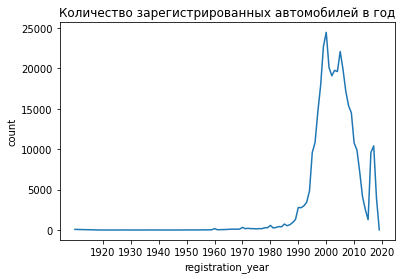

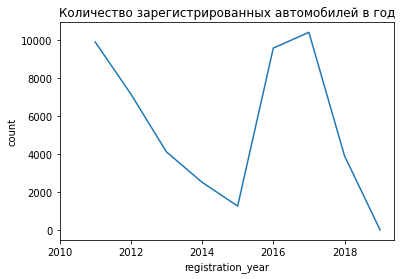

In [34]:
# Количесвто зарегестрированных автомобитей в год
pivot_table_date = date.pivot_table(index='registration_year', values='month_created', aggfunc='count').reset_index()
pivot_table_date.columns = ['registration_year','count']
pivot_table_date.plot(x='registration_year', y='count', xticks=np.arange(1920,2030, 10), legend=False).set(title='Количество зарегистрированных автомобилей в год', ylabel='count');
pivot_table_date.query('registration_year > 2010').plot(x='registration_year', y='count', xticks=np.arange(2010,2020, 2), legend=False).set(title='Количество зарегистрированных автомобилей в год', ylabel='count');

Из построенных графиков видно:
- максимальное количество зарегистриванных автомобилей 1995-2000 гг;
- резкий спад к 2015 г;
- в 2016 – 2017 гг был новый пик зарегистрированных автомобилей

- Выбросы

In [35]:
df.describe()

,price,registration_year,power,kilometer,registration_month,postal_code
count,353742.000000,353742.000000,353742.000000,353742.000000,353742.000000,353742.000000
mean,4419.839315,2003.101311,109.376642,128301.445686,5.720494,50515.116017
std,4514.184084,7.464051,38.991546,37777.635353,3.723951,25783.035155
min,0.000000,1910.000000,0.000000,5000.000000,0.000000,1067.000000
25%,1090.000000,1999.000000,75.000000,125000.000000,3.000000,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,49413.000000
75%,6400.000000,2008.000000,136.000000,150000.000000,9.000000,71088.000000
max,20000.000000,2019.000000,343.000000,150000.000000,12.000000,99998.000000


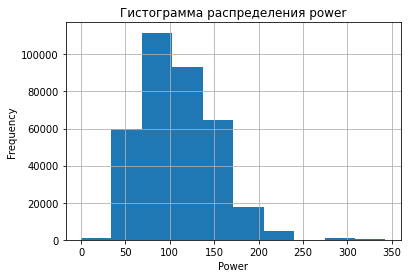

In [36]:
df.power.plot(kind='hist', grid=True).set(xlabel='Power', title='Гистограмма распределения power');

При аналезе гистограммы распределения параметра `power`,  обнаружены выбросы. Очистим данные от выбросов:

In [37]:
df = df.query('power >= 40 and power <= 200')

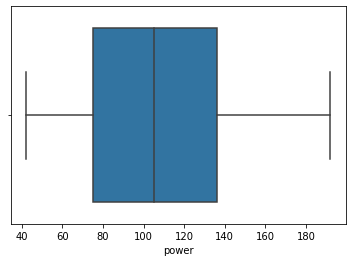

In [38]:
sns.boxplot(x=df['power']);

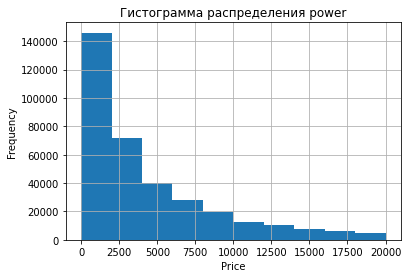

In [39]:
df.price.plot(kind='hist', grid=True).set(xlabel='Price', title='Гистограмма распределения power');

Удалим выбросы в параметре `price`:

In [40]:
df = df.query('price < 16000')

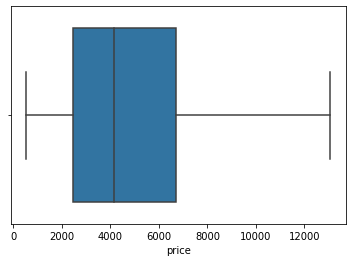

In [41]:
sns.boxplot(x=df.groupby('model')['price'].mean());

- Зависимость цены от признаков 

<AxesSubplot:>

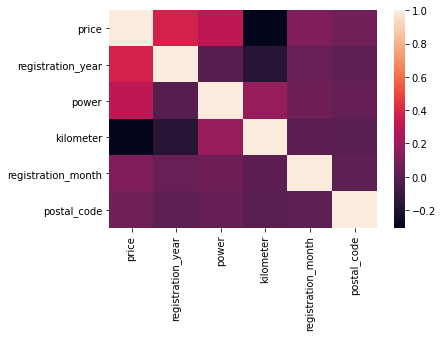

In [42]:
sns.heatmap(df.corr())

In [43]:
df.corr()

,price,registration_year,power,kilometer,registration_month,postal_code
price,1.000000,0.379443,0.310046,-0.306875,0.115790,0.072020
registration_year,0.379443,1.000000,-0.011837,-0.165913,0.042077,0.019762
power,0.310046,-0.011837,1.000000,0.186343,0.059352,0.038099
kilometer,-0.306875,-0.165913,0.186343,1.000000,0.009124,-0.005490
registration_month,0.115790,0.042077,0.059352,0.009124,1.000000,0.013308
postal_code,0.072020,0.019762,0.038099,-0.005490,0.013308,1.000000


Посмотрим как цена зависит от параметров: `registration_year`, `power`, `kilometer`

<AxesSubplot:xlabel='registration_year'>

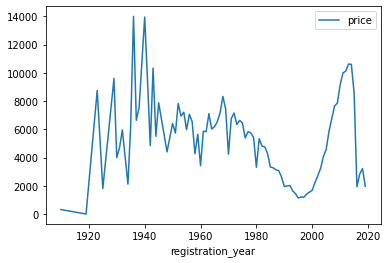

In [45]:
df.pivot_table(index='registration_year', values='price').reset_index().plot(x='registration_year')

<AxesSubplot:xlabel='power', ylabel='price'>

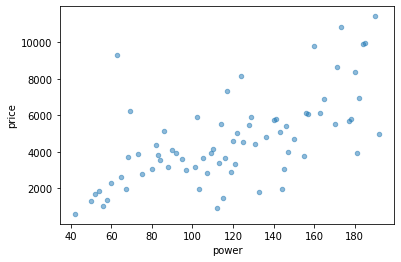

In [46]:
df.pivot_table(index='power', values='price').reset_index().plot(x='power', y='price', kind='scatter', alpha=0.5)

[Text(0.5, 1.0, 'Зависимость цены от пробега'), Text(0, 0.5, 'price')]

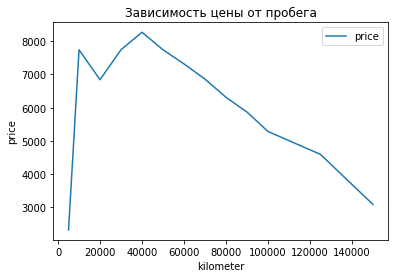

In [47]:
df.pivot_table(index='kilometer', values='price').reset_index().plot(x='kilometer', y='price').set(title='Зависимость цены от пробега', ylabel='price')

**Вывод**

- В данных `power` и `price`, были обнаружены и устранены выбросы;

По построенным графикам можно сделать следующие выводы:

- В 1995 г. количество регистраций автомобилей начинает расти, в этоже время растет и средняя цена, примерно в 2014 г. наблюдается резкий спад регистраций, на графике зависимости цены от года регистрации также видно как цена резко уменьшается. Можно сделать вывод, что цена зависит от количества зарегистривованных автомобилей в рассматриваемый временной промежуток.

- Коэффициент корреляции пирсона параметров `price` и `kilometer` равен `-0.3`, на графике зависимости также видно, что с увеличением пробега автомобиля снижается его цена.

- Коэффициент корреляции пирсона параметров `price` и `power` равен `0.3`, на диаграмме рассеиния можно увидеть прямолинейную зависимость цены и л.с.

- Удаление признаков: 

In [49]:
df = df.drop(columns=['date_crawled', 'registration_month', 'date_created', 'postal_code', 'last_seen'], axis=1)

In [50]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
0,480,sedan,1993,manual,95,golf,150000,petrol,volkswagen,no
2,9800,suv,2004,auto,157,grand,125000,gasoline,jeep,no
3,1500,small,2001,manual,95,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,75,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,143,3er,150000,petrol,bmw,yes


### Подготовка данных к обучению

In [51]:
data = df

Кодирование с применением технологии *`Ordinal Encoding`*

In [52]:
encoder = OrdinalEncoder()
data[['vehicle_type', 'fuel_type', 'gearbox', 'not_repaired', 'model',  'brand']] = OrdinalEncoder().fit_transform(df[['vehicle_type', 'fuel_type', 'gearbox', 'not_repaired', 'model',  'brand']])

In [53]:
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
0,480,4.0,1993,1.0,95,105.0,150000,6.0,38.0,0.0
2,9800,6.0,2004,0.0,157,106.0,125000,2.0,14.0,0.0
3,1500,5.0,2001,1.0,95,105.0,150000,6.0,38.0,0.0
4,3600,5.0,2008,1.0,75,91.0,90000,2.0,31.0,0.0
5,650,4.0,1995,1.0,143,10.0,150000,6.0,2.0,1.0


Разделим датафрейм на обучающую и тестовую выборки:
- обучающая выборка – 75%
- тестовая выборка – 25%

In [55]:
df_train, df_test = train_test_split(data, test_size=0.25, random_state=1234)

In [56]:
# Выделим признаки и целевой признак
train_features = df_train.drop('price', axis=1)
train_target = df_train.price
test_features = df_test.drop('price', axis=1)
test_target = df_test.price

Размеры полученных выборок:

In [57]:
print("Размер обучающей выборки –", train_features.shape)
print("Размер тестовой выборки –", test_features.shape)

Размер обучающей выборки – (251969, 9)
Размер тестовой выборки – (83990, 9)


## Обучение моделей

- Кросс-валидация

In [59]:
def get_cv_scores(model, features, target):
    scores=cross_val_score(
                            model,
                            features, target,
                            cv=5,
                            scoring="neg_root_mean_squared_error"
                            )
    print("best_score:", np.mean(scores)*(-1))

- GridSearchCV

In [60]:
grid_trg = {'max_depth': range(3, 15, 3)}

In [61]:
grid_rfr = {'n_estimators': range(5, 50, 10), 'max_depth': range(2, 15, 5)}

In [62]:
grid= {'learning_rate':[0.1], 'n_estimators': [50], 'max_depth': [15]}

### Подбор параметров моделей

- Модель линейной регрессии

In [63]:
model_lenrg = LinearRegression().fit(train_features, train_target)
get_cv_scores(model_lenrg, train_features, train_target)

best_score: 2909.5618917821666


- Модель решающего дерева

In [64]:
model_trg = DecisionTreeRegressor(random_state=RANDOM_STATE)
grid_search = GridSearchCV(model_trg, grid_trg, cv=5, scoring="neg_root_mean_squared_error")
grid_search.fit(train_features, train_target)
print(grid_search.best_params_)
print(grid_search.best_score_*(-1))

{'max_depth': 12}
1932.5473595432363


- Модель случайного леса

In [65]:
model_rfr = RandomForestRegressor(random_state=RANDOM_STATE)
grid_search = GridSearchCV(model_rfr, grid_rfr, cv=5, scoring="neg_root_mean_squared_error")
grid_search.fit(train_features, train_target)
print(grid_search.best_params_)
print(grid_search.best_score_*(-1))

{'max_depth': 12, 'n_estimators': 45}
1831.5288681517002


- Градиентный бустинг

In [66]:
model = LGBMRegressor(random_state=RANDOM_STATE)
# model.fit(train_features, train_target)
# get_cv_scores(model, train_features, train_target)
grid_search = GridSearchCV(model, grid, cv=5, scoring="neg_root_mean_squared_error")
grid_search.fit(train_features, train_target)
print(grid_search.best_params_)
print(grid_search.best_score_*(-1))

{'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 50}
1853.2877575761565


### Построение моделей на тестовой выборке

- Модель линейной регрессии

In [67]:
start = time.time()
model_lnr = LinearRegression().fit(train_features, train_target)
predicted_test = model_lnr.predict(test_features)
score_lnr = mean_squared_error(predicted_test, test_target) ** 0.5
print("score", score_lnr)
end = time.time()
time_lnr = end - start
print('time linear regression:', time_lnr)

score 2923.0686324048033
time linear regression: 0.11346840858459473


- Модель решающего дерева

In [68]:
start = time.time()
model_trg = DecisionTreeRegressor(max_depth=12, random_state=RANDOM_STATE).fit(train_features, train_target)
predicted_test = model_lenrg.predict(test_features)
score_trg = mean_squared_error(predicted_test, test_target) ** 0.5
print("score", score_trg)
end = time.time()
time_trg = end - start
print('time decision three regressor:', time_trg)

score 2923.0686324048033
time decision three regressor: 0.5926682949066162


- Модель случайного леса

In [69]:
start = time.time()
model_rfr = RandomForestRegressor(n_estimators=45, max_depth=12, random_state=RANDOM_STATE)
model_rfr.fit(train_features, train_target)
predicted_test = model_rfr.predict(test_features)
score_rfr = mean_squared_error(predicted_test, test_target) ** 0.5
print('score:', score_rfr)
end = time.time()
time_rfr = end - start
print('time random forest regressor:', time_rfr)

score: 1821.6492643748336
time random forest regressor: 14.353567123413086


**Градиентный бустинг**

In [70]:
start = time.time()
model_lgbmr = LGBMRegressor(learning_rate=0.1, n_estimators=45, max_depth=15, random_state=RANDOM_STATE)
model_lgbmr.fit(train_features, train_target)
predicted_test = model_lgbmr.predict(test_features)
score_lgbmr = mean_squared_error(predicted_test, test_target) ** 0.5
print('score:', score_lgbmr)
end = time.time()
time_lgbmr = end - start
print('time  LightGBM regressor :', time_lgbmr)

score: 1863.1860763815907
time  LightGBM regressor : 7.323498725891113


## Анализ моделей

In [71]:
data = [['linear_reg', time_lnr, score_lnr],
       ['dec_three_reg', time_trg, score_trg],
       ['random_forest_reg', time_rfr, score_rfr],
       ['LGBMreg', time_lgbmr, score_lgbmr]]
columns = ['model', 'time', 'score']

model_analysis = pd.DataFrame(data=data, columns=columns)
model_analysis

,model,time,score
0,linear_reg,0.113468,2923.068632
1,dec_three_reg,0.592668,2923.068632
2,random_forest_reg,14.353567,1821.649264
3,LGBMreg,7.323499,1863.186076


**Вывод**

Было проведено исследование предсказания цены автомобилей с помощию различных моделей машинного обучения. Анализ времени обучения показал, что модель линейной регрессии обучается на данных быстрее всего, однако имеет самое низкое качество. Самое высокое качество показала модель случайного леса.